In [4]:
import os
import sys
import warnings
import numpy as np

!{sys.executable} -m pip install numpy torch torchvision torchplot seaborn scipy sklearn jax jaxlib tqdm rich

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


# Rie-SNE

**Authors:** Andri Bergsson and Søren Hauberg 

**Affiliation:** Technical University of Denmark, Lyngby

# 1. Introduction and motivation

  Visualizations are crucial to investigators trying to make sense of high-dimensional data. The most common output of a visualization is a two-dimensional plot (e.g. on a piece of paper or a computer screen), so we often call on a form of dimensionality reduction when working with high-dimensional data. The vast majority of dimensionality reduction techniques assume that data resides on a Euclidean domain, which presents a problem when data is not quite that simple. Data residing on Riemannian manifolds, such as the sphere, appear in many domains where either known constraints or other modeling assumptions impose a Riemannian structure . In such settings, how should one visualize data?
  
  There are many concerns and questions when visualizing Riemannian data. The first is generic: all dimensionality reduction tools amplify parts of the signal, while reducing the remainder. This is an inherent limitation, which should always be in mind when interpreting data visualizations. Since some loss of information is inevitable, should we then loosen our grip on the data or its underlying Riemannian structure when such is present? Gauss's *Theorema Egregium* [1] informs us that if the final plot is to be presented on a *flat* screen or piece of paper, then a distortion of the Riemannian structure is inevitable.
  
  In practice, even if one accepts the limitations of a visualization, actual algorithms for visualizing Riemannian data are missing. In this paper, we develop an extension of the *Stochastic Neighbor Embedding* [2] method to Riemannian data and thereby provide one such tool. We call this *Riemannian Stochastic Neighbor Embedding*, or *Rie-SNE* for short. Our approach is quite general as it allows for embedding data observed on one Riemannian manifold to be embedded on another. This allows for mapping data from a Riemannian space to a two-dimensional Euclidean plane (for plotting), but also mapping to a two-dimensional sphere, or similar, when the Euclidean topology is inappropriate. Rie-SNE does not claim to solve the above-mentioned limitations of visualization, but it does provide a working tool, which we demonstrate to have practical merit.
  
<br></br>
<div>
<img src="img/intro_figure.svg" width="500"/>
</div>


# 2. Related Works

## Euclidean visualization

General data visualization is a vast topic, and a complete review is beyond our scope [3]. We here focus on the setting where data is represented as vectors (points) in a Euclidean space of high dimension. When data is two- or three-dimensional a scatter plot can directly reveal its structure, and we focus on the more difficult setting where data dimensions vastly exceed the easily plottable. Here one may explore the data through multiple projections, such as pairwise scatter plots, which is usually manageable for data of up to around 10 dimensions. Eventually the approach tends to become unwieldy and the greater picture is lost. Alternatives include continuously interpolating between dimensions to provide an (interactive) animation [4].
  
The approach we here explore is to find a non-linear mapping from the high-dimensional observation space into a two- or three-dimensional space, which is suitable for plotting. Many variants of this approach exists, and we only touch upon a few. *Principal component analysis (PCA)* [5] is perhaps the most commonly used approach to dimensionality reduction. This seeks a low-dimensional representation of data that preserves as much variance as possible. The restriction to spanning a linear subspace of the observation space, however, often implies that the low-dimensional view reveal little structure. The *Gaussian process latent variable model (GP-LVM)* [6] provides a nonlinear probabilistic extension of PCA that places a Gaussian process prior on the unknown mapping that reduce dimensionality, and marginalize this accordingly. The approach carries intrinsic elegance, but its optimization can be brittle [7]. Classic 'manifold learning' techniques avoid optimization issues by phrasing optimization tasks, where an optimum is available through spectral decompositions [8]-[10]. These rely on constructions of neighborhood graphs, which, however, can be brittle, so in practice the resulting visualizations are sensitive to parameter choices. The *stochastic neighbor embedding (SNE)* [2] replaces the 'hard' graph construction with a softer construction. A modern variant of this method [11] is one of the currently most popular algorithms, and is the one we here extend.

## Stochastic neighbor embedding
*Stochastic neighbor embedding (SNE)* [2] is a dimensionality reduction tool, which aims to preserve similarity between neighboring points when mapped to a low-dimensional representation. Assume for now, that we have access to function $s_{\text{high}}$ and $s_{\text{low}}$, which measure the similarity between observation pairs in the high-dimensional observation space and the low-dimensional representation space, respectively.

Now define the conditional probability, $p_{j|i}$ that $x_i$ would pick $x_j$ as its neighbor [11]
\begin{align}
  p_{j|i} = \frac{s_{\text{high}}(x_j | x_i)}{\sum_{k \ne i} s_{\text{high}}(x_k | x_i)}.
  \label{hdimp2}
\end{align}
Common convention is to define $p{i|i} = 0$. Further note that $\sum_j p_{j|i} = 1$. We can renormalize this to form a distribution over all observations as
\begin{gather}
  p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n},
  \label{hdimp1}
\end{gather}
 where $n$ is the number of observations.
    
To learn a low-dimensional representation, the key idea is to repeat the above over the low-dimensional space to form
    \begin{align}
      q_{j|i} &= \frac{s_{\text{low}}(y_j | y_i)}{\sum_{k \ne i} s_{\text{low}}(y_k | y_i)}, \\
      q_{ij}  &= \frac{q_{j|i} + q_{i|j}}{2n}.
    \end{align}
    We can now compare the similarity of our data and the representation by computing the Kullback-Leibler divergence between $p_{ij}$ and $q_{ij}$,
    \begin{align}
      C = \mathrm{KL}\left( P || Q \right) = \sum_{i=1}^n \sum_{j=1}^n p_{ij} \log \frac{p_{ij}}{q_{ij}}.
    \end{align}
    This can then be minimized using gradient descent with respect to the low-dimensional representation $\{ y_i \}_{i=1}^n$.

In its classic form, SNE picks the measures of similarity as Gaussian functions
    \begin{align}
    \begin{split}
      s_{\text{high}}(x_j | x_i)
        &= \left(2\pi\sigma_i^2\right)^{-\frac{D}{2}} \exp\left( -\frac{\| x_j - x_i \|^2}{2\sigma_i^2} \right), \\
      s_{\text{low}}(y_j | y_i)
        &= \left(2\pi\right)^{-\frac{d}{2}} \exp\left( -\frac{\| y_j - y_i \|^2}{2} \right).
    \end{split}\label{eq:sne_s}
    \end{align}
    With this choice, the normalization constants cancel out when computing $p_{j|i}$ and $q_{j|i}$.
    Note that this approach gives a per-observation variance $\sigma_i^2$, such that different points effectively can have different sizes of neighborhoods. To determine the $\sigma_i^2$ parameters, the user specifies a perplexity parameter, which can be thought of as a measure of the effective number of neighbors [11]. This is defined as
    \begin{align}
      \text{perplexity} = 2^{H\left(P_i\right)},
      \label{eq:perplexity}
    \end{align}
    where $H\left(P_i\right)$ is the Shannon entropy [12] of $P_i$ in bits:
    \begin{align}
      H\left(P_i\right) = - \sum_{j} p_{j|i} \log_2 p_{j|i}.
    \end{align}
    For a specific user-provided value of the perplexity parameter, we can perform a binary search over $\sigma_i^2$ such that holds. In practice, the user experiments with different choices of perplexities to see which reveals a pattern.

## The t-distributed stochastic neighbor embedding

The most popular variant of SNE is the *t-distributed SNE* [11]. This is motivated by the so-called 'crowding problem' often observed in SNE, where the low-dimensional representations significantly overlap without revealing much underlying structure. The idea is to use a similarity in representation space with more heavy tails than the Gaussian. Specifically, $s_{\text{low}}$ is chosen as a $t$-distribution with one degree of freedom centered around one representation, i.e.
\begin{align}
  s_{\text{low}}(y_j | y_i)
    &= \pi^{-1} \left( 1 + \|y_j - y_i\|^2 \right)^{-1}.
\end{align}
    
  As is evident, t-SNE needs to compute all pairwise distances between data points and therefore has quadratic complexity. Using approximation techniques, such as vantage-point trees or the *Barnes-Hut approximation*, the running time can be lowered down to having $\mathcal{O}(n \log n)$ complexity [13].

# 3. Implementation of Rie-SNE

### A key building block - Brownian Motion on a Riemannian manifold

The key building block for generalizing SNE to Riemannian manifolds is a suitable generalization of the Gaussian distribution. Here we consider a density derived from a Brownian motion on a Riemannian manifold for high-dimensional probability computations.

Given a Brownian motion in Euclidean space, the probability that the random walk will end in point $x$ can be computed by using the Gaussian density. If the increments of the Brownian motion are sufficiently small, each increment can be projected onto the tangent space of corresponding points on a Riemannian manifold without error. Then, a Brownian motion starting at point ${\lambda}$ running for some time $t$ can be projected onto a $D$-dimensional Riemannian manifold and there it will give rise to a random variable, a random variable that can be interpreted as the probability that a Brownian motion starting at ${\lambda}$ will end in point $x$ on the manifold. Since now the Brownian motion has been projected onto a Riemannian manifold the density will be different, and it can be approximated with a paramatrix expansion [14], [15]:
    
\begin{align}
  \mathcal{BM}(x|{\lambda}, t) &\approx
    \left( 2 \pi t \right)^{-\frac{D}{2}}H_{0} \exp \left( - \frac{\mathrm{dist}^2 (x, {\lambda})}{2t}\right)
  \label{eq:riemannianbrownianmotion}
\end{align}
    
where
    

* $t \in \mathbb{R}_+$ is the duration of the Brownian motion and corresponds to variance in Euclidean space.
* ${\lambda}$ is the starting point of the Brownian motion.
* $H_0$ is the ratio of Riemannian volume measures evaluated at points $x$ and ${\lambda}$ respectively, i.e.:
    \begin{align}
      H_0 = \left( \frac{\det G_{x}}{\det G_{{\lambda}}}\right)^{\frac{1}{2}}
    \end{align}
    with again $G_{{p}}$ being the metric evaluated at ${p}$.

Superficially, the above equation looks like the density of the normal distribution, with the Euclidean distance being replaced by its Riemannian counterpart. However, here it is worth noting that the normalization factor $H_0$ is different from the usual Euclidean distribution.

### The Rie-SNE Algorithm

*Rie-SNE* works in a similar manner as SNE and t-SNE, i.e. it will also produce two probability distributions $P$ and $Q$ from the data and aim to make them as similar as possible and in the process capture some underlying structure in the produced low dimensional embedding. However, computing the high-dimensional probability distribution $P$ comes with an added cost. To preserve the Riemannian nature of the data, a different density is used when computing high-dimensional probabilities belonging to $P$, namely the approximate density induced by the heat kernel of a Brownian motion on a Riemannian manifold, i.e. we pick
    \begin{align}
      s_{\text{high}}(x_j|x_i) &= \mathcal{BM}{x_j | x_i, t_i}.
    \end{align}
    The added computational cost is that the evaluation of $\mathcal{BM}(\cdot|\cdot)$ is more demanding than the conventional Gaussian similarity. Specifically, the normalization $H_0$ and the geodesic distance may be demanding, depending on the manifold on which the data resides.

With the Browninan motion model we get
\begin{align}
  p_{j|i} \approx \frac{
    H_{0}[i,j] \cdot  \exp \left( - \frac{\mathrm{dist}^2[i,j]}{2t_i}\right)
  }{\sum\limits_{k \ne i} H_{0}[i,k] \cdot \exp \left( - \frac{\mathrm{dist}^2[i,k]}{2t_i}\right)},
\end{align}
where we use the notations $\mathrm{dist}^2[i,j] = \mathrm{dist}^2(x_i,x_j)$ and $H_{0}[i,j] = \sqrt{ \frac{\det G_{x_i}}{\det G_{x_j}}}$ to emphasize that these quantities can be pre-computed. As with SNE, we can optimize $t_i$ to match a pre-specified perplexity using a binary search.

### Choice of representation

As mentioned, Gauss's *Theorema Egregium* [1] inform us that we cannot isometrically embed data from a curved space into a space of different curvature without introducing distortion. Specifically, if we embed data from a nonlinear manifold onto a *flat* two-dimensional representation (for plotting) then the curvature mismatch between spaces induces a distortion. This is a fundamental limitation that any visualization of Riemannian data will face, but we may nonetheless try to limit its impact. One approach is to embed the data onto a manifold of similar curvature as that of the manifold on which the data resides. For example, if the data resides on a high-dimensional sphere, it is perhaps more prudent to embed onto a two-dimensional sphere for plotting, rather than a Euclidean space.
    
With this in mind, we choose different distributions over the low-dimensional representation, depending on user preference. 

* **Euclidean.** If the user prefers a Euclidean low-dimensional representation, we opt to use a student-t as in regular t-SNE,
\begin{align}
s_{\text{low}}(y_j | y_i)
  &= \pi^{-1} \left( 1 + \|y_j - y_i\|^2 \right)^{-1}.
\end{align}

* **Spherical.** If the data manifold has positive curvature it may be beneficial to embed on a sphere, in which case we opt to use a von Mises-Fisher distribution [16]
\begin{align}
s_{\text{low}}(y_j | y_i)
  &= \left( \sqrt{2\pi} I_{\frac{d}{2}-1}(1) \right)^{-1} \exp\left( y_j^{\top} y_i \right),
\end{align}
where $I_{v}$ is a modified Bessel function of the first kind of order $v$. In practise the normalization constant cancels out and can be ignored.

* **Other.** The user may have other prior knowledge about the manifold on which the data resides, which may suggest embedding on some other low-dimensional manifold. In this case, we suggest to also use the Riemannian Brownian over the low-dimensional representation, i.e.,
\begin{align}
s_{\text{low}}(y_j | y_i)
  &= \mathcal{BM}(y_j | y_i, 1).
\end{align}

    
  Once we have defined both $s_{\text{high}}$ and $s_{\text{low}}$, we can estimate the representations using gradient descent just as regular SNE. Having performed $T$ iterations (with a sufficiently large value for $T$) of the gradient descent, the two probability distributions $P$ and $Q$ will have a minimal KL-divergence resulting in near-optimal positions of the points in the low-dimensional embedding.

### See the file `riesne.py` for the code implementation of Rie-SNE.

# 4. Test on Synthetic Datasets and Benchmark

## Benchmark

We benchmark Rie-SNE by comparing it to a known vizualisation method when it comes to visualizing Riemannian data, which is to map the data to the tangent space of a mean point and using PCA to reduce dimesionality. The following results are achieved for MNIST data points mapped to a high-dimensional (784 dimensional) sphere.

The top row shows spherical embeddings obtained using Rie-SNE, while the bottom row shows three-dimensional embeddings using the gold standard tangent space PCA. Note that the clustering structure is significantly more evident in Rie-SNE.
    
<br></br>
<div>
<img src="img/mnist6.svg" width="750"/>
</div>

Similarly, we can use Rie-SNE to generate a 2-dimensional embedding from the high-dimensional spherical MNIST data. Note how Rie-SNE discovers structure, which is lost on tangent space PCA.

<br></br>
<div>
<img src="img/mnist6_plane.svg" width="750"/>
</div>

Finally, we can try a different Riemannian manifold, namely the manifold of symmetric positive definite matrices. Following Mallasto et al. [17] we consider the price of 10 popular crypto-currencies over the time period 2.12.2014 — 15.5.2018. As is common in economy [18] the relationship between prices is captured by a 10 × 10 covariance matrix constructed from the past 20 days. This gives rise to a time series of covariance matrices, each of which reside on the cone of symmetric positive definite matrices. Rie-SNE is used to produce visualizations on both the plane $\mathbb{R}^2$ and the sphere $\mathbb{S}^2$, showing a one-dimensional structure capturing the time-evolution behind the data. In contrast, tangent space PCA produce $\mathbb{R}^2$ and $\mathbb{R}^3$ visualizations showing little to no structure in the embeddings.

<br></br>
<div>
<img src="img/crypto.svg" width="750"/>
</div>

# 5. Rie-SNE on MNIST

### Rie-SNE visualizations

Here we use Rie-SNE to create a 3D embedding from MNIST data points (digits 0 and 1) mapped onto a 784 dimensional sphere. We use a von Mises-Fisher distribution to compute the low-dimensional probabilities which results in a spherical low-dimensional embedding.

[Rie-SNE] Starting Rie-SNE ...


Output()

[Rie-SNE] Mean variance:0.02866534662246704
[Rie-SNE] KL divergence after 250 iterations with early exaggeration: 54.413108825683594
[Rie-SNE] KL divergence after 1000 iterations: 2.028538942337036


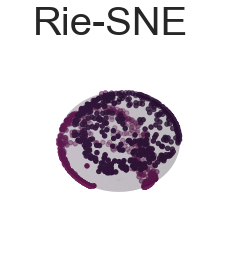

In [4]:
import torch
import torchvision.datasets
from riesne import Riesne
from models.sphere import Sphere


def spherical_mnist_test():
    # Determine model.
    model = Sphere(784)

    # Load data.
    subset_size = 1000 # -1 equals the entire data set.
    label_thresh = 2 # Include only a subset of MNIST classes.

    mnist_data = torchvision.datasets.MNIST('data/', train=True, download=True)
    X = mnist_data.data.reshape(-1, 784).float() / 255
    Y = mnist_data.targets

    idx = Y < label_thresh # Only use digits 0, 1, 2, ...
    X = X[idx][:subset_size]
    Y = Y[idx][:subset_size]

    # Project MNIST data onto sphere.
    X /= X.norm(dim=1).unsqueeze(1)

    # Run Rie-SNE.
    print(f"[Rie-SNE] Starting Rie-SNE ...")
    riesne = Riesne(model, n_components=3, init='sphere')
    transformed = riesne.fit_transform(X.cpu().numpy())
    # Plot.
    model.plot_points(transformed, Y, 'Rie-SNE')

spherical_mnist_test()

Similarly, we use RIE-SNE to create a low-dimensional embedding of MNIST data (digits 0 and 1) mapped onto a 784 dimensional sphere, but this time we use a student's t-distribution to compute the low-dimensional probabilities, yielding a Euclidean low-dimensional embedding. 

[Rie-SNE] Starting Rie-SNE ...


Output()

[Rie-SNE] Mean variance:0.027036935210227965
[Rie-SNE] KL divergence after 250 iterations with early exaggeration: 60.1108644111689
[Rie-SNE] KL divergence after 1000 iterations: 0.7424519231571799


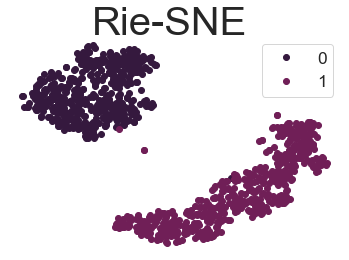

In [3]:
import torch
import torchplot as plt
import torchvision.datasets
from riesne import Riesne
from models.euclidean import Euclidean
import seaborn as sns
sns.set()


def mnist_test():
    # Determine model.
    model = Euclidean(784)

    # Load data.
    subset_size = 1000 # -1 equals the entire data set.
    label_thresh = 2 # Include only a subset of MNIST classes.

    mnist_data = torchvision.datasets.MNIST('data/', train=True, download=True)
    X = mnist_data.data.reshape(-1, 784).float() / 255
    Y = mnist_data.targets

    idx = Y < label_thresh # Only use digits 0, 1, 2, ...
    X = X[idx][:subset_size]
    Y = Y[idx][:subset_size]
    
    # Project MNIST data onto sphere.
    X /= X.norm(dim=1).unsqueeze(1)

    # Run Rie-SNE.
    print(f"[Rie-SNE] Starting Rie-SNE ...")
    riesne = Riesne(model, n_components=2)
    transformed = riesne.fit_transform(X.cpu().numpy())
    
    # Plot.
    sns.set_style("white")
    sns.set_palette("rocket")
    fig, ax = plt.subplots(1, 1)
    labels = Y
    for label in labels.unique():
        idx = labels == label
        points = transformed[idx]
        ax.plot(points[:, 0], points[:, 1], 'o')
    plt.xticks([], [])    
    plt.yticks([], [])    
    plt.legend([str(i) for i in labels.unique().tolist()],fontsize='x-large', title_fontsize='40')
    ax.set_axis_off()
    fig.suptitle('Rie-SNE', fontsize=40)
    plt.show()


mnist_test()

# 5. References

1. Karl Friedrich Gauss and Peter Pesic. General investigations of curved
surfaces. Courier Corporation, 2005
2. Geoffrey E Hinton and Sam Roweis. Stochastic neighbor embedding.
In S. Becker, S. Thrun, and K. Obermayer, editors, Advances in Neural
Information Processing Systems, volume 15, pages 857–864. MIT Press, 2003.
3. Jake VanderPlas. Python data science handbook: Essential tools for
working with data. ” O’Reilly Media, Inc.”, 2016.
4. Daniel Asimov. The grand tour: a tool for viewing multidimensional
data. SIAM journal on scientific and statistical computing, 6(1):128–
143, 1985.
5. Ian T Jolliffe. Principal component analysis for special types of data.
Springer, 2002.
6. Neil Lawrence. Probabilistic non-linear principal component analysis
with gaussian process latent variable models. The Journal of Machine
Learning Research, 6:1783–1816, 2005.
7. Cilie W. Feldager, Søren Hauberg, and Lars Kai Hansen. Spontaneous
symmetry breaking in data visualization. In International Conference
on Artificial Neural Networks (ICANN), 2021.
8. Joshua B Tenenbaum, Vin de Silva, and John C Langford. A global
geometric framework for nonlinear dimensionality reduction. science,
290(5500):2319–2323, 2000.
9. Sam T Roweis and Lawrence K Saul. Nonlinear dimensionality
reduction by locally linear embedding. science, 290(5500):2323–2326, 2000.
10. Mikhail Belkin and Partha Niyogi. Laplacian eigenmaps for dimension-
ality reduction and data representation. Neural computation, 15(6):1373–
1396, 2003.
11. Laurens van der Maaten and Geoffrey Hinton. Visualizing data using
t-SNE. Journal of Machine Learning Research, 9:2579–2605, 2008.
12. Claude E. Shannon. A mathematical theory of communication. Bell
Syst. Tech. J., 27(3):379–423, 1948.
13. Laurens van der Maaten. Accelerating t-sne using tree-based algorithms.
J. Mach. Learn. Res., 15(1):3221–3245, January 2014.
14. E.P. Hsu and American Mathematical Society. Stochastic Analysis on
Manifolds. Graduate studies in mathematics. American Mathematical
Society, 2002.
15. Dimitris Kalatzis, David Eklund, Georgios Arvanitidis, and Søren
Hauberg. Variational autoencoders with riemannian brownian motion
priors, 2020.
16. Kanti V Mardia, Peter E Jupp, and KV Mardia. Directional statistics,
volume 2. Wiley Online Library, 2000.
17. Anton Mallasto, Søren Hauberg, and Aasa Feragen. Probabilistic
riemannian submanifold learning with wrapped gaussian process latent
variable models. In Proceedings of the 19th international Conference
on Artificial Intelligence and Statistics (AISTATS), 2018.
18. Andrew Gordon Wilson and Zoubin Ghahramani. Generalised wishart
processes. arXiv preprint arXiv:1101.0240, 2010.